This is the my notebook for the Kaggle competition of [House Price Prediction](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). I got inspired by many other great kernels and blog posts:

**A great blog post for beginners:** https://www.dataquest.io/blog/kaggle-getting-started/

**A great kernel for EDA:** https://www.kaggle.com/xchmiao/detailed-data-exploration-in-python

**A great walk-through over the problem:** https://www.kaggle.com/apapiu/regularized-linear-models

**A great tutorial of stacking:** https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

I may have forgotten other great works. I would like to thank the authors of these kernels/posts for their work.

In [1]:
# To make mutlti-processing work on macOS
from multiprocessing import set_start_method
set_start_method('forkserver')

### Import libraries and prepare for data visualization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-paper')
sns.set_style('white')
sns.set_context('paper')

/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Read datasets

In [3]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [4]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


### Dealing with missing values

#### Missing values in the training dataset

In [6]:
train.columns[train.isnull().sum()>0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

#### Missing values in the test dataset

In [7]:
test.columns[test.isnull().sum()>0]

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

### Log transformation of target

The original target has a skewed distribution. Log-transformation makes the distribution more "normal".

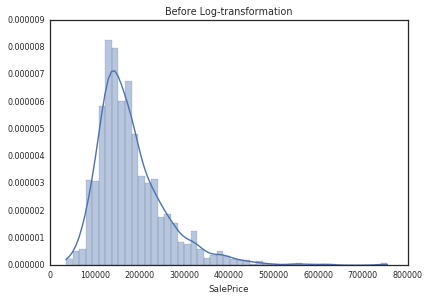

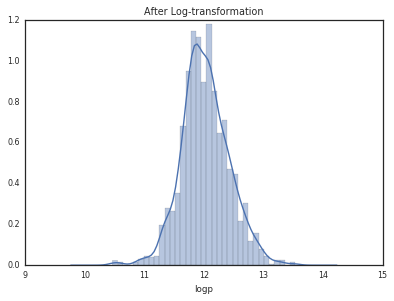

In [8]:
sns.distplot(train['SalePrice'])
plt.title('Before Log-transformation')
# train['SalePrice'].plot(kind='hist', title='Before Log-transformation')
train['logp'] = np.log(train.SalePrice)
plt.figure()
sns.distplot(train['logp'])
plt.title('After Log-transformation')

#### Identify and remove outliers

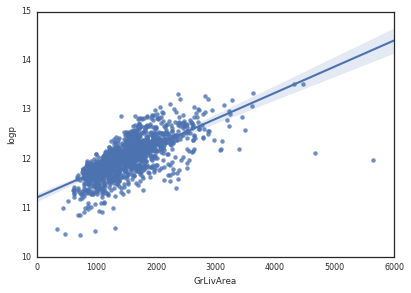

In [9]:
sns.regplot('GrLivArea', 'logp', data=train)

There are two data points with large GrLivArea value that look like outliers.

In [10]:
# Remove outliers
train = train[(train['GrLivArea'] <= 4000) & (train['GarageArea'] <= 1200)]

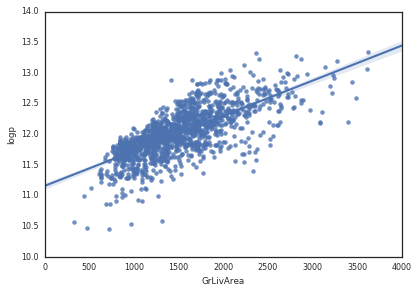

In [11]:
sns.regplot('GrLivArea', 'logp', data=train)

### Feature engineering

The feature engineering process is simple. It is summarized as follows:
* Missing values are imputed.
* Skewed continuous numerical features are log-transformed.
* Continuous numerical features are standardized.
* Numerical features which are essentially categorical features are converted to categorical features.
* One-hot encoding is used to deal with categorical features.

#### Combining training and test dataset

In [12]:
combined = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']], axis=0)

#### Imputing missing values in the training dataset
Missing value in many features actually implies zero value or none. Therefore Missing values should be handled with care in these features.

In [13]:
# Deal with missing values
none_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
        'FireplaceQu', 'GarageType', 'MasVnrType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 
        'Fence', 'MiscFeature']  # Features where missing value implies none

mode_cols = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 
             'Functional', 'SaleType']  # Features where mode is used to fill missing values
zero_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'MasVnrArea',
             'BsmtHalfBath', 'GarageCars', 'GarageArea'] # Features where zero is used to fill missing values
combined[zero_cols] = combined[zero_cols].fillna(0)

combined[none_cols] = combined[none_cols].fillna('None')
combined.LotFrontage.fillna(combined.LotFrontage.mean(), inplace=True)
combined.GarageYrBlt.fillna(1800, inplace=True)
combined.Electrical.fillna('SBrkr', inplace=True)  # mode of train.Electrical

for col in mode_cols:
    combined[col].fillna(combined[col].mode()[0], inplace=True)

combined.columns[combined.isnull().sum()>0]

Index([], dtype='object')

### Correlations between features and the target

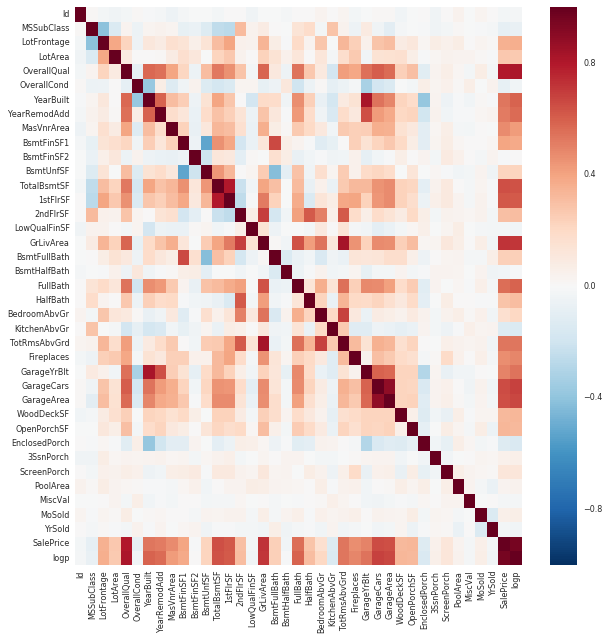

In [14]:
corr = train.corr()
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(corr)

In [15]:
corr['SalePrice'].sort_values()[:8]

KitchenAbvGr    -0.139006
EnclosedPorch   -0.129693
MSSubClass      -0.086856
OverallCond     -0.080717
BsmtHalfBath    -0.036559
Id              -0.026935
LowQualFinSF    -0.025256
YrSold          -0.024567
Name: SalePrice, dtype: float64

#### Transform skewed data

In [16]:
continuous_vars = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch',\
                'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MiscVal',\
                'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']  # Continuous variables
skew_threshold = 2
for entry in continuous_vars:
    if combined[entry].skew() > skew_threshold:
        combined[entry] = np.log1p(combined[entry])

#### Standardize continuous variables

In [17]:
from sklearn.preprocessing import StandardScaler
sub_df = combined[continuous_vars]
array_standard = StandardScaler().fit_transform(sub_df)
combined[continuous_vars] = array_standard

In [18]:
combined.shape

(2911, 79)

#### Categorical features

#### Transform numerical features which essentially are categorical features

In [19]:
combined['MSSubClass'] = combined['MSSubClass'].astype(str)

#### Use one-hot  encoding to transform categorical features into numerical features

In [20]:
combined = pd.get_dummies(combined)

X_train = combined[0: train.shape[0]]
X_test = combined[train.shape[0]:]
y = train.logp

In [21]:
combined.shape

(2911, 316)

## Building regression models

In [22]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor 
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics
from sklearn.base import BaseEstimator, clone, TransformerMixin, RegressorMixin
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Use nested cross-validation to tune parameter and evaluate the performance of algorithms.

In [23]:
def rmse(estimator, train=X_train.values, target=y.values, n_folds=5, shuffle=True, random_state=13):
    cv = KFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state).split(train)
    score = np.sqrt(-cross_val_score(estimator, train, target, scoring='neg_mean_squared_error', cv=cv))
    print('cross validation score of {} is: {:.4f} +/- {:.4f}'.format(estimator.__class__.__name__, np.mean(score), np.std(score)))

#### Ridge regression

In [24]:
ridge = RidgeCV(alphas=np.arange(16,18,.2),
    cv=10, normalize=True,
    scoring='neg_mean_squared_error')

In [25]:
rmse(ridge, shuffle=False)

cross validation score of RidgeCV is: 0.1126 +/- 0.0054


#### Lasso 

In [26]:
lasso = LassoCV(eps=1e-2, n_alphas=500, cv=10, normalize=True)

In [27]:
rmse(lasso)

cross validation score of LassoCV is: 0.1118 +/- 0.0117


### ElasticNet

In [28]:
enet = ElasticNet(alpha=1e-4, l1_ratio=0.9, normalize=True)

In [29]:
rmse(enet)

cross validation score of ElasticNet is: 0.1114 +/- 0.0119


### Gradient boosting

In [30]:
gb = GradientBoostingRegressor(learning_rate=.008, n_estimators=6000, min_samples_split=4, max_depth=2,
                                             random_state=11, max_features=120, min_samples_leaf=6, subsample=.8)

In [31]:
rmse(gb)

cross validation score of GradientBoostingRegressor is: 0.1154 +/- 0.0107


### Xgboost

In [32]:
xgb = XGBRegressor(learning_rate =0.01, n_estimators=2500, max_depth=4, min_child_weight=5, gamma=0,
                    subsample=0.75, colsample_bytree=0.75, reg_alpha=0.0002, objective= 'reg:linear', seed=27)

In [33]:
rmse(xgb)

cross validation score of XGBRegressor is: 0.1153 +/- 0.0122


### Kernel Ridge Regression

In [34]:
kr = KernelRidge(kernel='polynomial', degree=1.4, alpha=6, coef0=2.5)

In [35]:
rmse(kr)

cross validation score of KernelRidge is: 0.1128 +/- 0.0132


***Linear models perform better in this problem.***

### Stacked generalization
Stacked generalization is a effecient ensemble method to improve the model.

In [36]:
class StackedModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5, random_state=None):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state = random_state
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        self.out_of_fold_predictions_ = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train, holdout in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train], y[train])
                y_pred = instance.predict(X[holdout])
                self.out_of_fold_predictions_[holdout, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(self.out_of_fold_predictions_, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [37]:
stacked_model = StackedModel(base_models = (xgb, gb, kr, enet), meta_model = lasso)

In [38]:
rmse(stacked_model)

cross validation score of StackedModel is: 0.1095 +/- 0.0129


***CV score of stacked model is better than to any of base/meta model.*** Unfortunately stacked model does not improve public LB score. It is possible that public LB score is not an accurate evaluation of the model performance since only a small portion of the test set is used to evaluate public LB score. It is believed that CV score is more accurate than public LB score.

In the end a linear combination of the predictions of ridge regression and stacked model is used as the final submission. This is another method of improving model performance. In this case it improves public LB score from ... to ....

In [39]:
stacked_model.fit(X_train.values, y.values)
pred = stacked_model.predict(X_test.values)

In [48]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = np.exp(pred) * 0.25 + np.exp(p) * 0.75
sub.head()
sub.to_csv('submission.csv', index=False)  # LB score: 0.11682

1. Ridge regression obtained a CV score of 0.1126 and a public LB score of 0.11699.
2. Stacked generalization obtained a CV score of 0.1095 and a public LB score of 0.11932.
3. The final submission obtained a public LB score of 0.11682 (top 13%).
4. The final submission used a ensemble method to obtain improved results over the original models of ridge regression and stacked generalization model.